In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

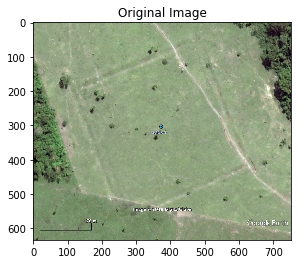

In [2]:
# Let us import the image

img = cv2.imread('./images/acds4.png')
plt.imshow(img)
plt.title('Original Image')
plt.show()

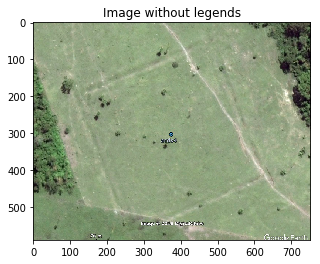

In [3]:
# We cut the image to get rid of legends, copyright information etc.

geo = img[:590,:,:]
plt.imshow(geo)
plt.title('Image without legends')
plt.show()

In [4]:
# Converts to gray scale and calculates among the pixel values the ones corresponding to
# the 13.8% and the 87.1% percentiles. These percentiles were determined to be the optimal parameters
# for the binary thresholding method applied to this class of images

gray = cv2.cvtColor( geo, cv2.COLOR_BGR2GRAY)
b = np.reshape(gray, (gray.shape[0]*gray.shape[1]))
c = b.tolist()
c.sort()
Percentile_Inf = int(13.8*len(c)/100)+1
Percentile_Sup = int(87.1*len(c)/100)+1

In [5]:
# Applies a kind of binary threshold with parameters that vary from image to image,
# but that are statistically invariant among members of the same class.

ggray = np.zeros(gray.shape, dtype = np.uint8)

for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
        if gray[i][j] > c[Percentile_Sup] or gray[i][j] < c[Percentile_Inf]:
            ggray[i][j] = 255
            
Imag_binary = np.array(ggray,dtype = np.uint8)

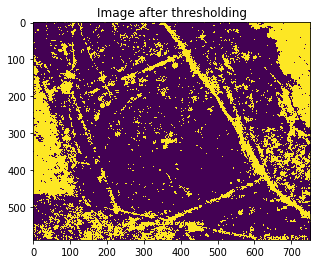

In [6]:
# Thresholding result

plt.imshow(Imag_binary)
plt.title('Image after thresholding')
plt.show()

In [7]:
# Blurring

sub_binary=cv2.medianBlur(Imag_binary,3)

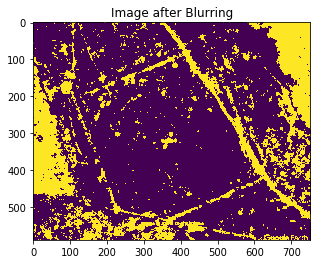

In [8]:
# Blurring result

plt.imshow(sub_binary)
plt.title('Image after Blurring')
plt.show()

In [9]:
# Skeletonization and line detection

copy = geo
size = np.size(sub_binary)
skel = np.zeros(sub_binary.shape,np.uint8)

# This thresholding is done since some image classes may require a non-binary thresholding at the beginning 
# (see In [5]).

ret,sub_binary = cv2.threshold(sub_binary,100,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False
 
while( not done):
    eroded = cv2.erode(sub_binary,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(sub_binary,temp)
    skel = cv2.bitwise_or(skel,temp)
    sub_binary = eroded.copy()
 
    zeros = size - cv2.countNonZero(sub_binary)
    if zeros==size:
        done = True
        
edges = cv2.Canny(skel,5,50)

# I must still implement a dinamical specification of HoughLines' parameter 'threshold' (here = 100)
# for the number of lines returned by the function varies greatly from image to image.
# The idea is to call HoughLines in a loop with a different value for the parameter 'threshold' in each iteration
# and halt when the number of lines found is anywhere between 10 and 100 (the function performs better when its output 
# is in that range). Later the program will filter most of these lines.

lines = cv2.HoughLines(edges,1,np.pi/180,100)
number_of_lines_found = lines.shape[0]

for lin in lines:
    #rho = lin[0][0]
    #theta = lin[0][1]
    rho,theta = lin[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(copy,(x1,y1),(x2,y2),(128,255,0),2)

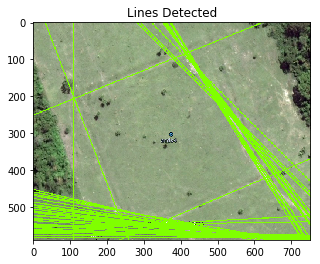

In [10]:
# Lines found

# My main concern is to improve the algorithm's sensitivity. Since the program aims to help the identification 
# of possible candidates (to be manually confirmed later), specificity is not a concern.
# That said, I must still implement some filters in order to get only meaningful lines. Also, I will implement
# the identification of rectangle parts.

plt.imshow(copy)
plt.title('Lines Detected')
plt.show()